In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt


# Load the Flowers Dataset

In [2]:
# Load dataset from TensorFlow Datasets
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    as_supervised=True,
    with_info=True
)

# Print number of classes
num_classes = metadata.features['label'].num_classes
print(f"Number of classes: {num_classes}")


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/tf_flowers/incomplete.OQK7TH_3.0.1/tf_flowers-train.tfrecord*...:   0%|   …

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.
Number of classes: 5


In [3]:
IMG_SIZE = 224

def format_example(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
    return image, label

train = raw_train.map(format_example).shuffle(1000).batch(32).prefetch(1)
validation = raw_validation.map(format_example).batch(32).prefetch(1)
test = raw_test.map(format_example).batch(32).prefetch(1)


In [4]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,  # Remove final classification layer
    weights='imagenet'
)
base_model.trainable = False  # Freeze the base


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [5]:
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │         6,405 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,264,389 (8.64 MB)

 Trainable params: 6,405 (25.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [6]:
EPOCHS = 5

history = model.fit(
    train,
    validation_data=validation,
    epochs=EPOCHS
)


Epoch 1/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 32s 218ms/step - accuracy: 0.6157 - loss: 0.9877 - val_accuracy: 0.8638 - val_loss: 0.4169
Epoch 2/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.8753 - loss: 0.3776 - val_accuracy: 0.8937 - val_loss: 0.3341
Epoch 3/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.9117 - loss: 0.2961 - val_accuracy: 0.8856 - val_loss: 0.3319
Epoch 4/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9267 - loss: 0.2431 - val_accuracy: 0.9155 - val_loss: 0.2887
Epoch 5/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.9441 - loss: 0.2100 - val_accuracy: 0.9101 - val_loss: 0.2858


In [7]:
loss, accuracy = model.evaluate(test)
print(f"Test accuracy: {accuracy:.2f}")


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.8978 - loss: 0.2967
Test accuracy: 0.90


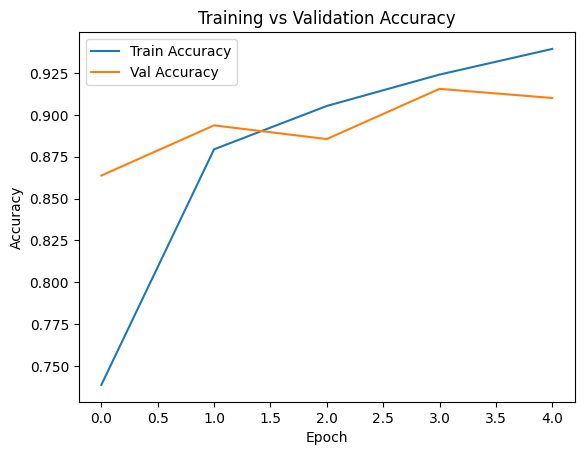

In [8]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


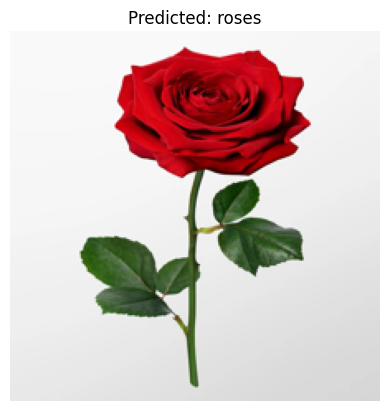

In [10]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Define class labels
flower_names = ['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

# Load and prepare your image
image = Image.open("/content/rose.webp").resize((224, 224))
img_array = np.array(image)
img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)
img_array = tf.expand_dims(img_array, 0)

# Predict
predictions = model.predict(img_array)
predicted_class = tf.argmax(predictions[0])

# Show image and prediction
plt.imshow(image)
plt.axis('off')
plt.title(f"Predicted: {flower_names[predicted_class.numpy()]}")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


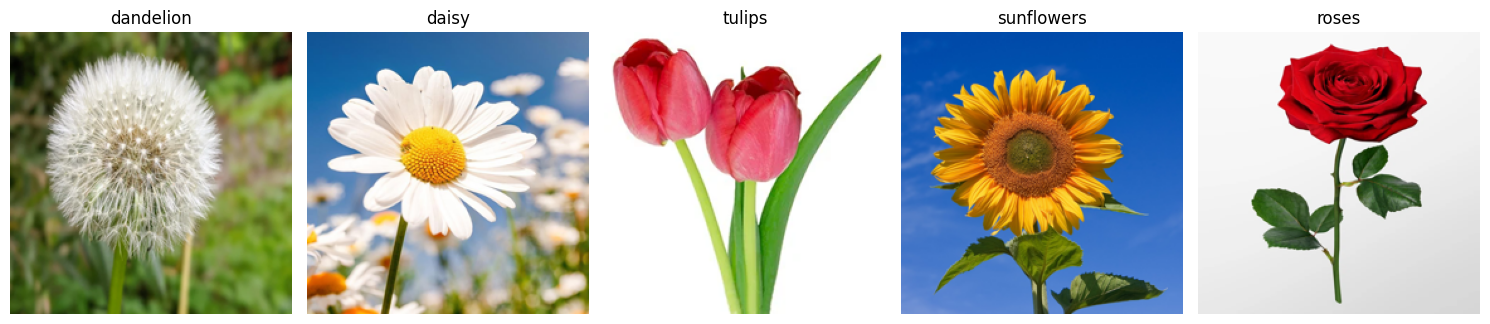

In [11]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Flower labels
flower_names = ['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

# Set up plot
plt.figure(figsize=(15, 5))

#  image paths
image_paths = [
    "/content/dand6.webp",
    "/content/daisy.jpg",
    "/content/Tulip.webp",  #
    "/content/Sunflower.jpg",
    "/content/rose.webp"
]

# Loop over 5 images
for i, path in enumerate(image_paths):
    # Load and preprocess
    image = Image.open(path).resize((224, 224))
    img_array = np.array(image)
    img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)
    img_array = tf.expand_dims(img_array, 0)

    # Predict
    predictions = model.predict(img_array)
    predicted_class = tf.argmax(predictions[0]).numpy()

    # Show image and prediction
    plt.subplot(1, 5, i + 1)
    plt.imshow(image)
    plt.axis('off')
    plt.title(flower_names[predicted_class])

plt.tight_layout()
plt.show()